<a href="https://colab.research.google.com/github/zw2791/Real-Data-Practices/blob/main/Hotel_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA on Hotel Booking Data

Data downloaded from:  [Kaggle](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand)


Original data:  [Hotel booking demand datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191)


## Import libraries and define auxiliary functions

In [ ]:
# basic
import pandas as pd
import numpy as np
# imputation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
# time series
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
# plot
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns
import plotly.express as px
# warnings
import warnings; warnings.filterwarnings("ignore")

### Functions

In [ ]:
# Define a funcion to check for missing values
# and return only columns with nulls
def missing(df):
  missing = df.isnull().sum().sort_values(ascending=False)
  missing = missing.get(missing > 0).to_frame().reset_index()
  missing.columns = ['column', 'n_missing']
  missing['p_missing'] = missing.n_missing.apply(lambda x: (x / len(df) * 100)).round(2)
  missing.p_missing = missing.p_missing.astype(str) + '%'
  return missing

In [ ]:
# define a function to plot monthly devision line
def m_division():
    for year in range(2015, 2018):
      if year == 2015:
        for month in range(8, 13):
            plt.axvline(datetime(2015,month,1), color='k', linestyle='--', alpha=0.5)
      elif year == 2016:
        for month in range(1, 13):
            plt.axvline(datetime(2016,month,1), color='k', linestyle='--', alpha=0.5)
      elif year == 2017:
        for month in range(1, 9):
            plt.axvline(datetime(2017,month,1), color='k', linestyle='--', alpha=0.5)

In [ ]:
# define a function to create a new feature from agent and company
def id_type(df):
  Id_type = []
  for index, row in df[['agent', 'company']].iterrows():
    if not pd.isnull(row['agent']):
      Id_type.append('agent')
    elif not pd.isnull(row['company']):
      Id_type.append('company')
    else:
      Id_type.append('individual')
  return Id_type

## Read Data

In [ ]:
# load data files from google drive
from google.colab import drive
drive.mount('/content/drive')

# load data
path = '/content/drive/MyDrive/hotel_bookings.csv'
df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
r, c = df.shape
print(f"This dataset has {r} rows and {c} columns")

This dataset has 119390 rows and 32 columns


In [ ]:
# display the maximum number of columns
pd.set_option('display.max_columns', None)

# inspect dataset
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


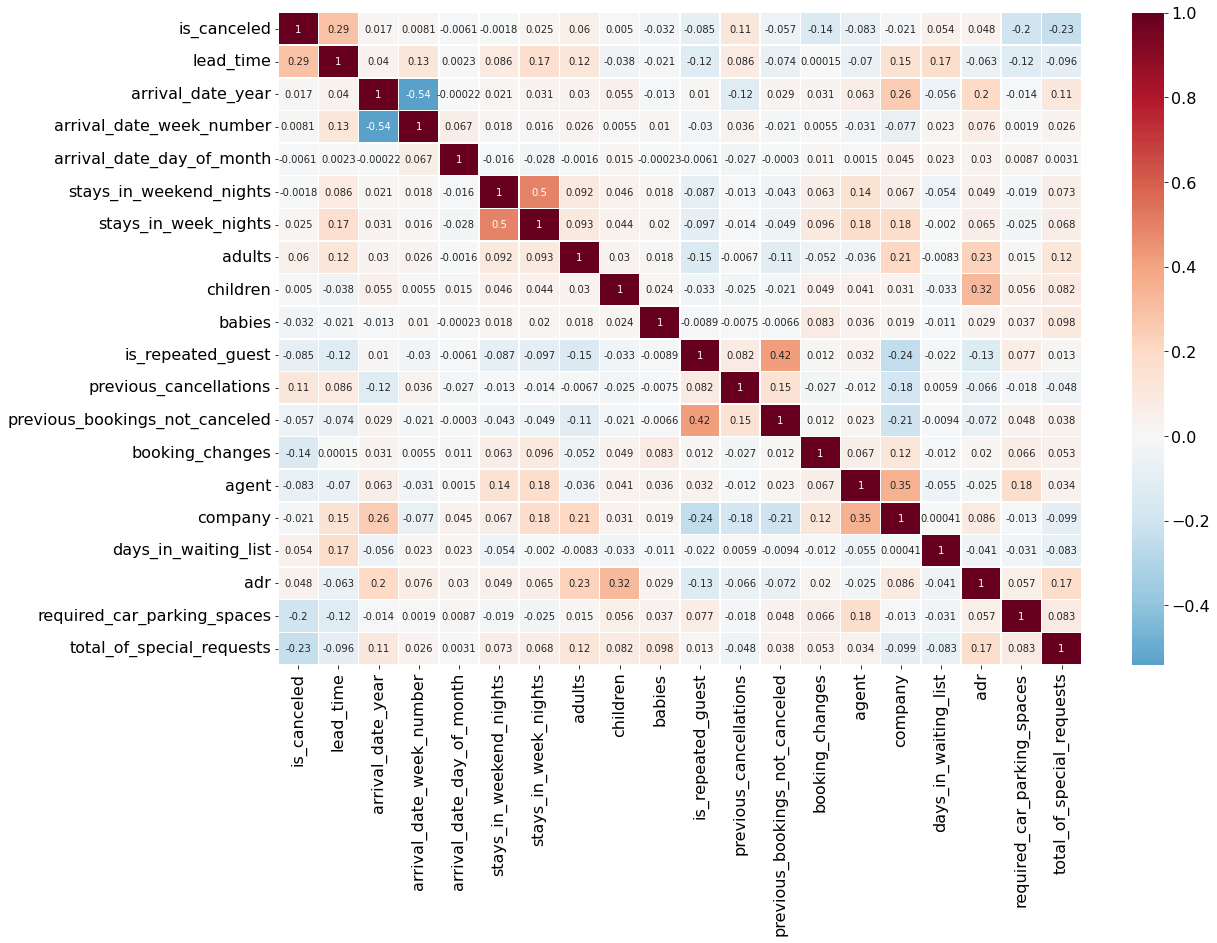

In [ ]:
# form a correlation matrix
corrM = df.corr()
# plot
plt.figure(figsize=(18,12))
plt.rcParams['font.size'] = '16' # set font size globally
print('')
print('')
print('')
sns.heatmap(corrM, center=0, linewidths=.5, annot=True, annot_kws={"size": 10}, cmap="RdBu_r");

In [ ]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

We notice that a few columns contain missing values, and most columns are numeric

### Feature Aggregation

In [ ]:
# make a time variable
df['arrival_date'] = pd.to_datetime(df.arrival_date_year.astype(str) \
                      + ' ' + df.arrival_date_month.astype(str) \
                      + ' ' + df.arrival_date_day_of_month.astype(str))

## Check Potential Data Quality Issues

### 1. Handle missing values

In [ ]:
# show only columns that have null values 
m = missing(df); m

,column,n_missing,p_missing
0,company,112593,94.31%
1,agent,16340,13.69%
2,country,488,0.41%
3,children,4,0.0%


In [ ]:
# inspect columns with missing values
df[m.column].head()

,company,agent,country,children
0,NaN,NaN,PRT,0.0
1,NaN,NaN,PRT,0.0
2,NaN,NaN,GBR,0.0
3,NaN,304.0,GBR,0.0
4,NaN,240.0,GBR,0.0


We notice agent, country, and children have only a small proportion of nulls. However, company is almost a empty column, there is a rule in the data sicence that we can remove data with more than 70% - 80% null values, so we will decide if we want to remove company

In [ ]:
# see what values the copany have
df.company.value_counts()

40.0     927
223.0    784
67.0     267
45.0     250
153.0    215
        ... 
104.0      1
531.0      1
160.0      1
413.0      1
386.0      1
Name: company, Length: 352, dtype: int64

Since both company and agent column mean the hotel reserve id number, so we want to know if they are complementary

In [ ]:
# check the relationship of company and agent
c = df[df['company'].notnull()] # where company value is not null
# check the % of empty agent values with non-null company values
p = c.agent.isna().mean(); p

0.9680741503604532

We proved that they are almost complementary

In [ ]:
# how many rows have both agent and company are null
df.agent.isna().sum() - c.agent.isna().sum()

9760

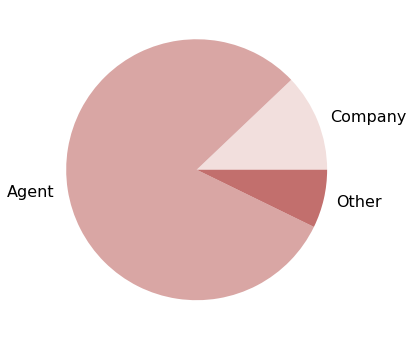

In [ ]:
# create labels
a_c_n = [16340, 112593*p, 9760]
label = ['Company', 'Agent', 'Other']
# plot
plt.figure(figsize=(10,6))
colors2 = sns.color_palette("vlag")[3:6]
plt.pie(a_c_n, labels=label, colors=colors2)
plt.show()

The possible real meaning of label 'other' could be the individual id. Based on this assumption, we can generate a new feature as it_type to replace column agent and company

In [ ]:
# call pre_defined function
df['id_type'] = id_type(df)
df.id_type.value_counts()

agent         103050
individual      9760
company         6580
Name: id_type, dtype: int64

#### Impute columns with a small proportion of missing values

In [ ]:
# check unique values in column children
df.children.value_counts()

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

According to metadata, the children column refers the number of children in the hotel. 

In [ ]:
# In this case, we will just use mode to impute
mode = df.children.mode()[0] # 0.0
df.children = df.children.fillna(mode)

For country we will use mode to impute as it is categorical

In [ ]:
# check unique values in column country
df.country.value_counts()

PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: country, Length: 177, dtype: int64

In [ ]:
# impute with the most frequent value
mode1 = df.country.mode()[0] # PRT
df.country = df.country.fillna(mode)

Let's remove agent, company and add id_type

In [ ]:
# copy with a condition
df = df.drop(['agent', 'company'], axis=1)

In [ ]:
# check missing value again
m = missing(df); m

,column,n_missing,p_missing


### Anomaly detection (on arrival date)

In [ ]:
# check the time peroid
start, end = df.arrival_date.min(), df.arrival_date.max()
print(f"Date starts from {start} and ends in {end}")

Date starts from 2015-07-01 00:00:00 and ends in 2017-08-31 00:00:00


In [ ]:
# make it a independent dataframe
ts = df.arrival_date.value_counts().reset_index()
ts.columns = ['ds', 'y'] # simple name
ts = ts.sort_values(by='ds', ascending=True).reset_index().drop('index', axis=1)
ts.tail()

,ds,y
788,2017-08-27,174
789,2017-08-28,211
790,2017-08-29,125
791,2017-08-30,89
792,2017-08-31,134


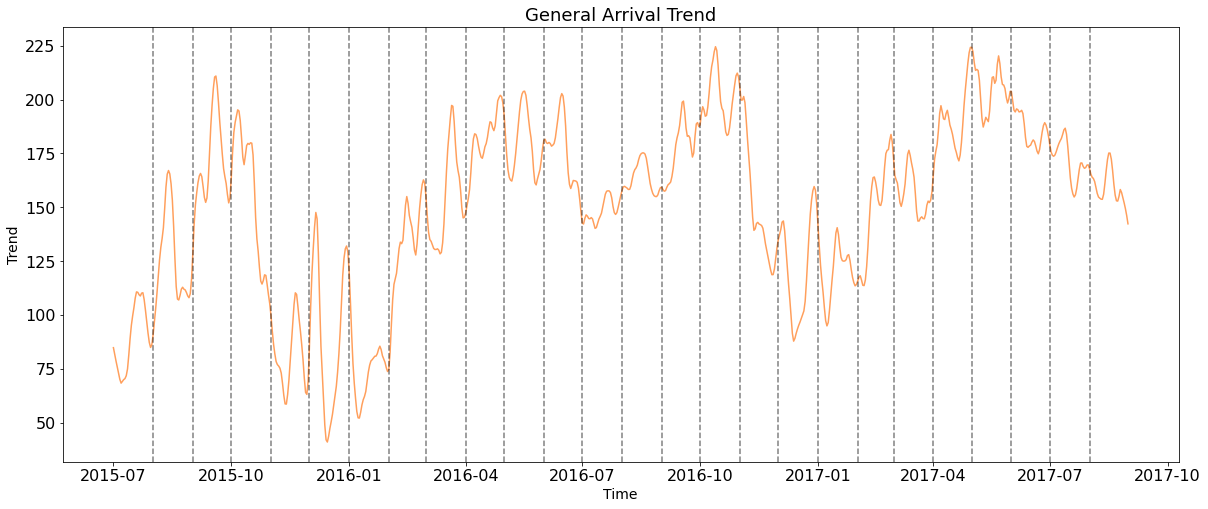

In [ ]:
# if we want to investigate in a monthly basis 
freq = int(len(ts)/30)
# modity data format
ts = ts.reset_index(drop='index') #inplace=True)
ts.index = pd.to_datetime(ts['ds'])
# build a Seasonal-Trend Decomposition (STD) model
result = STL(ts.y, seasonal=13).fit()
# plot general trend
plt.figure(figsize=[20,8])
sns.lineplot(data=result.trend, color = '#FF9F5C')
m_division()
plt.title("General Arrival Trend", fontsize = 18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Trend", fontsize=14)
plt.show()

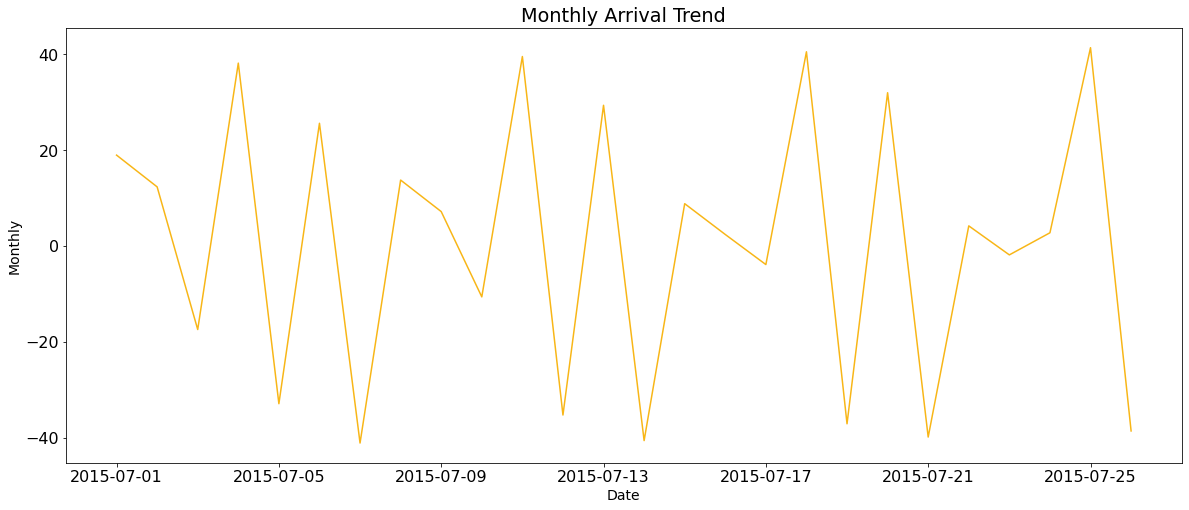

In [ ]:
# Change the style of plot
plt.figure(figsize=[20,8])
# plot montly pattern
plt.title("Monthly Arrival Trend")
sns.lineplot(data=result.seasonal[:freq], ci='sd', color = '#F8B617')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Monthly", fontsize=14)
plt.show()

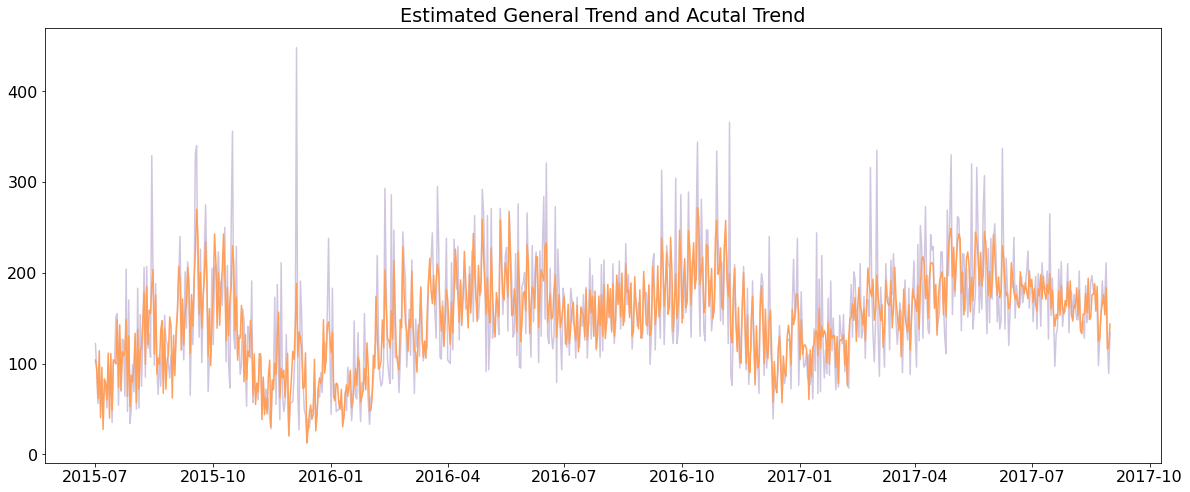

In [ ]:
estimated = result.trend + result.seasonal
# plot
plt.figure(figsize=[20,8])
plt.plot(ts.y, color='#D1C6E0')
plt.plot(estimated, color = '#FF9F5C')
plt.title("Estimated General Trend and Acutal Trend");

In [ ]:
# define residuel
# Detect outliers using three sigma method
resid = result.resid
resid_mu = resid.mean()
resid_dev = resid.std()
# 3 std
lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev
# Anomaly detection
anomalies = ts[(resid < lower) | (resid > upper)]
n = anomalies.shape[0]
print(f"Using STD method, we detected {n} anomalies")

Using STD method, we detected 9 anomalies


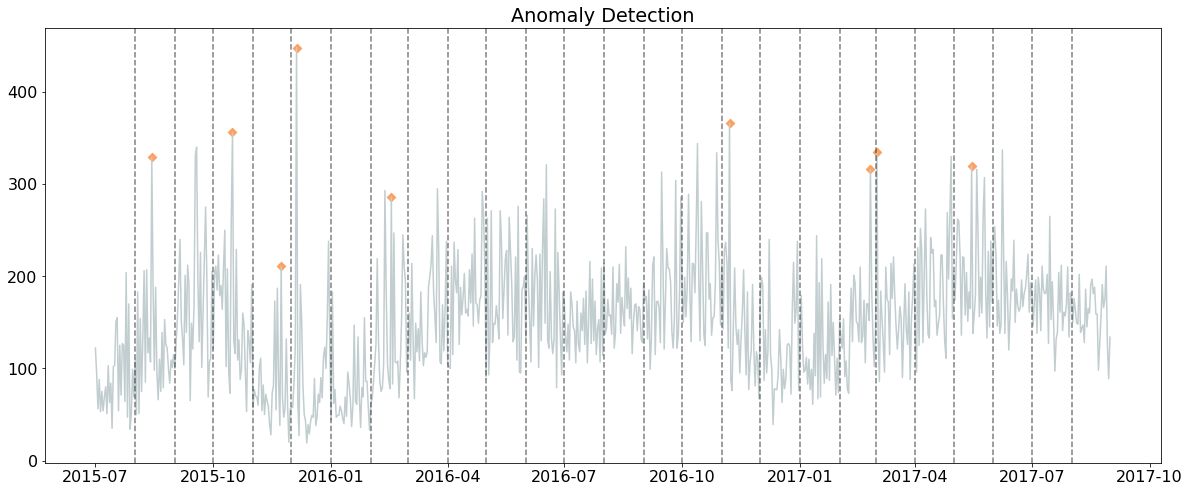

In [ ]:
# highlight anomalies in the plot
plt.figure(figsize=[20,8])
plt.plot(ts.y, color = '#C1CDCF')
m_division() # call the function
plt.scatter(anomalies.index, anomalies.y, color='#FF9F5C', marker='D')
plt.title("Anomaly Detection")
plt.show()

In [ ]:
# look anomalies
anomalies.reset_index(drop=True)

,ds,y
0,2015-08-14,329
1,2015-10-16,356
2,2015-11-23,211
3,2015-12-05,448
4,2016-02-17,286
5,2016-11-07,366
6,2017-02-25,316
7,2017-03-02,335
8,2017-05-15,320


### Detect outliers

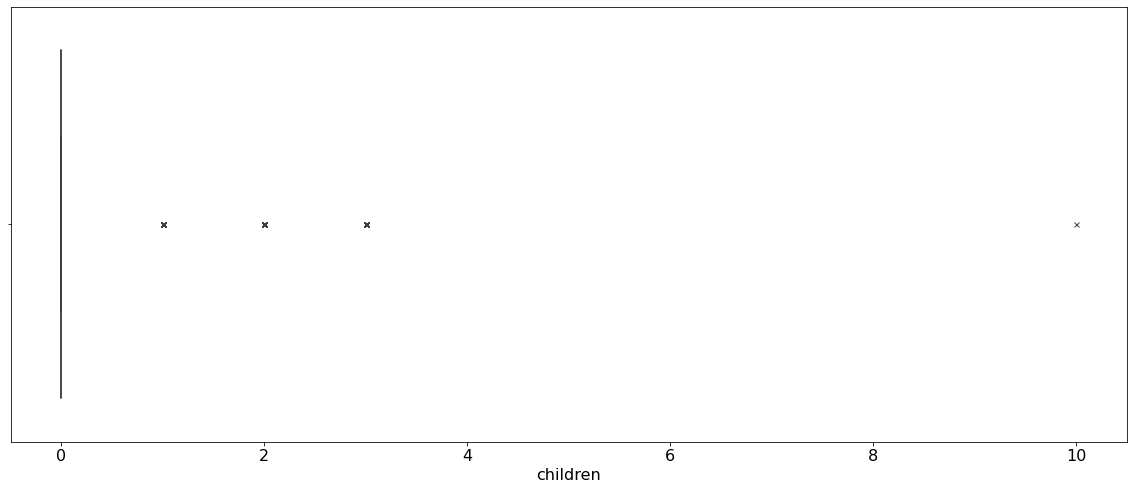

In [ ]:
# Number of adults
plt.figure(figsize=[20,8])
sns.boxplot(x=df.children, flierprops={"marker": "x"})
plt.show()

We see some extreme outliers, and we will dig into it

In [ ]:
df.sort_values('adults', ascending=False).head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,id_type
2173,Resort Hotel,1,338,2015,October,41,4,2,0,55,0.0,0,HB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,0,Group,0.0,0,0,Canceled,2015-01-02,2015-10-04,individual
1643,Resort Hotel,1,336,2015,September,37,7,1,2,50,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,0,Group,0.0,0,0,Canceled,2015-01-18,2015-09-07,individual
1539,Resort Hotel,1,304,2015,September,36,3,0,3,40,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,0,Group,0.0,0,0,Canceled,2015-01-02,2015-09-03,individual
1917,Resort Hotel,1,349,2015,September,39,21,1,3,27,0.0,0,HB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,0,Group,0.0,0,0,Canceled,2015-01-02,2015-09-21,individual
1962,Resort Hotel,1,352,2015,September,39,24,1,3,27,0.0,0,HB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,0,Group,0.0,0,0,Canceled,2015-01-02,2015-09-24,individual


### Feature Encoding

In [ ]:
df.market_segment.value_counts()

Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: market_segment, dtype: int64

In [ ]:
# find the Frequency of each unique categorical values
enc_ms = (df.groupby('market_segment').size()) / len(df)
enc_ms # show frequency

market_segment
Aviation         0.001985
Complementary    0.006223
Corporate        0.044350
Direct           0.105587
Groups           0.165935
Offline TA/TO    0.202856
Online TA        0.473046
Undefined        0.000017
dtype: float64

In [ ]:
df['enc_ms'] = df['market_segment'].apply(lambda x : enc_ms[x])

In [ ]:
df['enc_ms'].head()

0    0.105587
1    0.105587
2    0.105587
3    0.044350
4    0.473046
Name: enc_ms, dtype: float64

ecoding another one using a different method

In [ ]:
df.customer_type.value_counts()

Transient          89613
Transient-Party    25124
Contract            4076
Group                577
Name: customer_type, dtype: int64

In [ ]:
pd.get_dummies(df.customer_type, drop_first=True)

,Group,Transient,Transient-Party
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
119385,0,1,0
119386,0,1,0
119387,0,1,0
119388,0,1,0


In [ ]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,id_type,enc_ms
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,individual,0.105587
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,individual,0.105587
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,individual,0.105587
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,agent,0.044350
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,agent,0.473046


### Feature Scaling

In [ ]:
#df.hist(figsize=(50,50), color='#FF9F5C')
#plt.savefig("hist.pdf", format="pdf", bbox_inches="tight")
#plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['lead_time_n'] = scaler.fit_transform(df.lead_time.values.reshape(-1,1))

df.lead_time_n.tail()

119385   -0.758089
119386   -0.018822
119387   -0.655153
119388    0.046682
119389    0.945032
Name: lead_time_n, dtype: float64

In [ ]:
df.lead_time.values

array([342, 737,   7, ...,  34, 109, 205])

## EDA (Visualization)

### Correlation heatmap

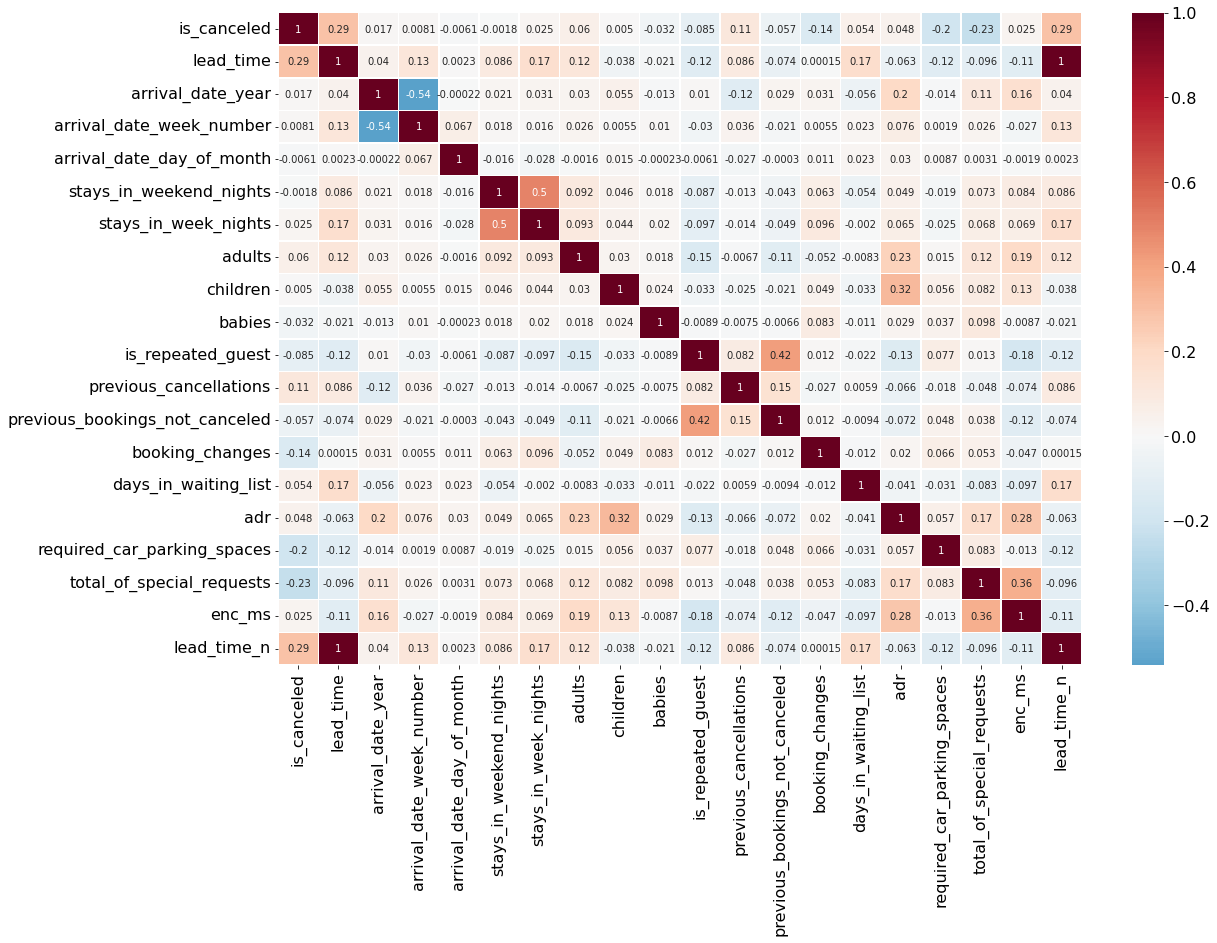

In [ ]:
# form a correlation matrix
corrM = df.corr()
# plot
plt.figure(figsize=(18,12))
plt.rcParams['font.size'] = '16' # set font size globally
print('')
print('')
print('')
sns.heatmap(corrM, center=0, linewidths=.5, annot=True, annot_kws={"size": 10}, cmap="RdBu_r");

### 1.Which market segments have the most cancelled reservations?

In [ ]:
# calculate the percentage of reservation status and market segment
rs = df.reservation_status.value_counts().reset_index()
rs['percentage'] = rs['reservation_status'] / sum(rs['reservation_status'])
rs

,index,reservation_status,percentage
0,Check-Out,75166,0.629584
1,Canceled,43017,0.360307
2,No-Show,1207,0.010110


In [ ]:
ms = df.market_segment.value_counts().reset_index()
ms['percentage'] = ms['market_segment'] / sum(ms['market_segment'])
ms

,index,market_segment,percentage
0,Online TA,56477,0.473046
1,Offline TA/TO,24219,0.202856
2,Groups,19811,0.165935
3,Direct,12606,0.105587
4,Corporate,5295,0.044350
5,Complementary,743,0.006223
6,Aviation,237,0.001985
7,Undefined,2,0.000017


In [ ]:
df1 = df.groupby(['reservation_status','market_segment'])[['reservation_status']].count()
df1.columns = ['count']
df1 = df1.reset_index()
df1

,reservation_status,market_segment,count
0,Canceled,Aviation,41
1,Canceled,Complementary,85
2,Canceled,Corporate,916
3,Canceled,Direct,1722
4,Canceled,Groups,12023
5,Canceled,Offline TA/TO,8080
6,Canceled,Online TA,20148
7,Canceled,Undefined,2
8,Check-Out,Aviation,185
9,Check-Out,Complementary,646


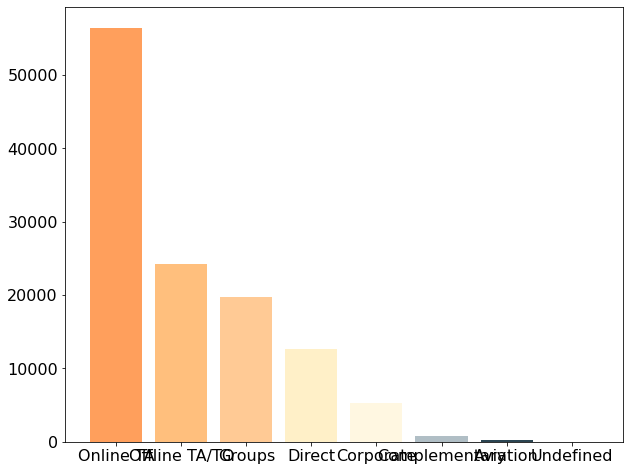

In [ ]:
# market segment bar graph
plt.figure(figsize=[10,8])
color = ['#FF9F5C', '#FFBF7D', '#FFCA95','#FFF0C8','#FFF7E1','#B0BEC5','#2B4552']
plt.bar(x=ms['index'], height= ms['market_segment'], color=color)
plt.show()

In [ ]:
# select 'Canceled' category
canceled_rs = df1[df1.reservation_status== 'Canceled']
canceled_rs = canceled_rs.sort_values(by=['count'])

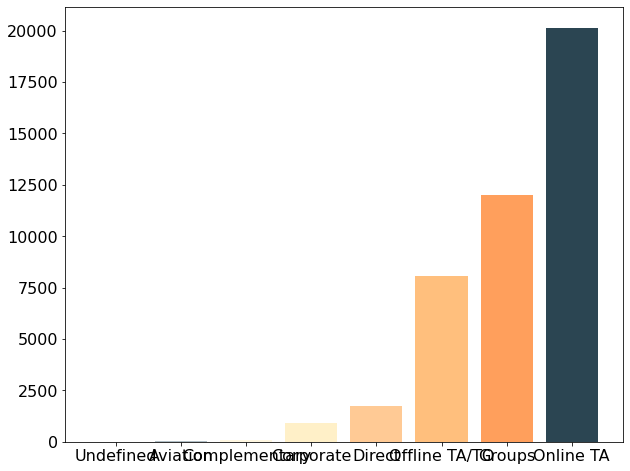

In [ ]:
# market segment in canceled status
plt.figure(figsize=[10,8])
color1 = ['#2B4552', '#B0BEC5','#FFF7E1', '#FFF0C8', '#FFCA95', '#FFBF7D','#FF9F5C']
plt.bar(x=canceled_rs['market_segment'], height= canceled_rs['count'], color=color1)
plt.title('')
plt.show()

In [ ]:
fig = px.sunburst(df1, path=['reservation_status', 'market_segment'], values='count', 
                  color_discrete_sequence=['#FF9F5C','#FFF0C8','#B0BEC5'])
fig.update_layout(title='Different Market Segments for each Reservation Status',
                  width=700, height=500)

fig.show()

### 2. To discover the room type

In [ ]:
room_level = df.reserved_room_type.value_counts().reset_index()
room_level.rename({'A':'Cheapest', 'D':'', 'E':'', 'F':'', 'G':'', 'B':'', 'C':'', 'H':'', 'P':'', 'L':'Most Expensive'})

,index,reserved_room_type
0,A,85994
1,D,19201
2,E,6535
3,F,2897
4,G,2094
5,B,1118
6,C,932
7,H,601
8,P,12
9,L,6
